![](heart_attack_banner.jpeg){fig-align="center"}

In [169]:
# Importing the dataset
import pandas as pd

ha = pd.read_csv("https://www.dropbox.com/s/aohbr6yb9ifmc8w/heart_attack.csv?dl=1")

In [170]:
ha

,age,sex,cp,trtbps,chol,restecg,thalach,output
0,63,1,3,145,233,0,150,1
1,37,1,2,130,250,1,187,1
2,56,1,1,120,236,1,178,1
3,57,0,0,120,354,1,163,1
4,57,1,0,140,192,1,148,1
...,...,...,...,...,...,...,...,...
268,59,1,0,164,176,0,90,0
269,57,0,0,140,241,1,123,0
270,45,1,3,110,264,1,132,0
271,68,1,0,144,193,1,141,0


*The sex, cp, and restecg variables are in categorical form, so they will be excluded from scaling.*

In [171]:
# Checking the value counts of the 'output' variable
ha['output'].value_counts()

1    146
0    127
Name: output, dtype: int64

*It looks like the training and test splits will be balanced, as there isn't an unbalanced ratio of values, therefore no need to stratify.*

In [172]:
# Checking the counts of the 'sex' variable
ha['sex'].value_counts()

1    184
0     89
Name: sex, dtype: int64

*Male to female ratio is unbalanced, as males are known to be twice as likely to experience a heart attack when compared to females.*

In [173]:
# Binning by age group and getting counts of each
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

age_groups = pd.cut(ha['age'], bins)
age_groups.value_counts().sort_index()

(0, 10]        0
(10, 20]       0
(20, 30]       1
(30, 40]      17
(40, 50]      66
(50, 60]     117
(60, 70]      67
(70, 80]       5
(80, 90]       0
(90, 100]      0
Name: age, dtype: int64

*The age range of 50-61 has nearly twice as many rows as the next age range of 70-81, and 40-51.*

In [174]:
# Checking for missing values in each column
ha.isna().sum()

age        0
sex        0
cp         0
trtbps     0
chol       0
restecg    0
thalach    0
output     0
dtype: int64

*There are no NA values, and it looks like the categorical variables sex, cp, and restecg will be dummified, with the other variables being scaled as well.*

# **Part One: Fitting Models**

This section asks you to create a final best model for each of the model types studied this week. For each, you should:

Find the best model based on ROC AUC for predicting the target variable.

Output a confusion matrix; that is, the counts of how many observations fell into each predicted class for each true class.

Report the (cross-validated!) ROC AUC metric.

Fit the final model.

(Where applicable) Interpret the coefficients and/or estimates produced by the model fit.

You should certainly try multiple model pipelines to find the best model. You do not need to include the output for every attempted model, but you should describe all of the models explored. You should include any hyperparameter tuning steps in your writeup as well.

In [175]:
# Importing libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_selector

In [176]:
# Defining the response and predictor variables
X = ha.drop('output', axis=1)
y = ha['output']

In [177]:
# Initializing the column transformer
ct = ColumnTransformer(
    [
        ("dummify", OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='first'), make_column_selector(dtype_include=object)),
        ("standardize", StandardScaler(), ['age', 'trtbps', 'chol', 'thalach'])
    ],
    remainder="passthrough"
)

X = ct.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# *Q1: KNN*

In [178]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score
from sklearn.model_selection import GridSearchCV

In [179]:
np.sqrt(273)

16.522711641858304

*The sqrt of 273 (16.5) was used for a starting point in obtaining an optimal hyperparameter set to test with. Each tuned model was tested to make sure that the AUC of the full model was not **100%**, which would suggest overfitting.*

In [180]:
# Defining the hyperparameters for tuning
param_grid1 = {
    'n_neighbors': [1, 3, 5],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

knn = KNeighborsClassifier()

In [181]:
# Performing a GridSearchCV
grid_search1 = GridSearchCV(estimator=knn, param_grid=param_grid1, cv=5, scoring='roc_auc')
grid_search1.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': [1, 3, 5],
                         'weights': ['uniform', 'distance']},
             scoring='roc_auc')

In [182]:
# Defining the best hyperparameters and model
best_model1 = grid_search1.best_estimator_

# Printing out the test accuracy
accuracy1 = best_model1.score(X_test, y_test)
print(f"Test Accuracy: KNN k=5 [{accuracy1}]")

Test Accuracy: KNN k=5 [0.6666666666666666]


*    The test accuracy of **66.7%** represents the percentage of true positives and negatives that were predicted by the best K-Nearest Neighbors model.

In [183]:
# Printing out the best hyperparameters
best_params1 = grid_search1.best_params_

print("Best Hyperparameters:", best_params1)

Best Hyperparameters: {'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'uniform'}


*    After initially using a k-nearest neighbors value of 16.52 as a starting point, the parameters were adjusted until the sweet spot of 5 for nearest neighbors was chosen. Anything over 5 resulted in overfitting.

In [184]:
# Model KNN with K=5
best_model1.fit(X_train, y_train)
pred_1 = best_model1.predict(X_test)

In [185]:
# Calculating the average AUC across all folds

from sklearn.model_selection import cross_val_score

cv_auc_scores1 = cross_val_score(best_model1, X_train, y_train, cv=5, scoring='roc_auc')

avg_auc_score1 = cv_auc_scores1.mean()
print(f"Average Cross-Validated AUC: KNN k=5 [{avg_auc_score1}]")

Average Cross-Validated AUC: KNN k=5 [0.8205513784461154]


*    The average cross-validated AUC for the model tuned on the training set was approximately **82.1%**, which translates to having a significantly higher chance of predicting the risk of heart attack than by random chance.

*Fitting on the Full Model with the best hyperparameters*

In [186]:
# Fitting the full model
best_model1.fit(X, y)
pred_best1 = best_model1.predict(X)

In [187]:
# Confusion matrix Full Model
conf_matrix_best1 = confusion_matrix(y, pred_best1)
print("Confusion Matrix: KNN k=5")
print(conf_matrix_best1)

Confusion Matrix: KNN k=5
[[100  27]
 [ 25 121]]


*    100 TN: There were 100 correct predictions that patients were not at risk of a heart attack.
*    27 FP: There were 27 incorrect predictions that patients were at risk of a heart attack, when they were not.
*    25 FN: There were 25 instances where the model failed to identify those who were at risk of a heart attack.
*    121 TP: There were 121 instances where the model correctly predicted those who were at risk of a heart attack.

In [188]:
# AUC Full Model
prob_1 = best_model1.predict_proba(X)
auc_score_1 = roc_auc_score(y, prob_1[:, 1])
print(f"AUC: KNN k=5 [{auc_score_1}]")

AUC: KNN k=5 [0.8985007011109912]


*    The KNN k=5 model has an AUC of **89.9%** which was higher than the predictions made on the test set.

# *Q2: Logistic Regression*

In [189]:
from sklearn.linear_model import LogisticRegression

In [190]:
# Defining the hyperparameters for tuning
param_grid2 = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2']
}

log_reg = LogisticRegression(solver='liblinear')

In [191]:
# Performing a GridSearchCV
grid_search2 = GridSearchCV(log_reg, param_grid2, cv=5, scoring='roc_auc')
grid_search2.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(solver='liblinear'),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'penalty': ['l1', 'l2']},
             scoring='roc_auc')

In [192]:
# Defining the best hyperparameters and model
best_model2 = grid_search2.best_estimator_

# Printing out the test accuracy
accuracy2 = best_model2.score(X_test, y_test)
print(f"Test Accuracy: LogReg C=100, penalty=L1 [{accuracy2}]")

Test Accuracy: LogReg C=100, penalty=L1 [0.6811594202898551]


*    The test accuracy of **68.1%** represents the percentage of true positives and negatives that were predicted by the logistic regression model.

In [193]:
# Printing out the best hyperparameters
best_params2 = grid_search2.best_params_
print("Best Hyperparameters:", best_params2)

Best Hyperparameters: {'C': 100, 'penalty': 'l1'}


*    The best hyperparameters were a combination of both a regularization strength(C) of 100 and a L1 Lasso penalty.

In [194]:
# Model Logistic Regression with C=100, penalty=L1
best_model2.fit(X_train, y_train)
pred_2 = best_model2.predict(X_test)

In [195]:
# Calculating the average AUC across all folds
cv_auc_scores2 = cross_val_score(best_model2, X_train, y_train, cv=5, scoring='roc_auc')

avg_auc_score2 = cv_auc_scores2.mean()
print(f"Average Cross-Validated LogReg C=100, penalty=L1 [{avg_auc_score2}]")

Average Cross-Validated LogReg C=100, penalty=L1 [0.8798587377534746]


*    The average cross-validated AUC of the logistic regression model was **88%**, and this is significantly higher than predicting from just random chance.

*Fitting on the Full Model with the best hyperparameters*

In [196]:
# Fitting the full model
best_model2.fit(X, y)
pred_best2 = best_model2.predict(X)

In [197]:
# Confusion matrix Full Model
conf_matrix_2 = confusion_matrix(y, pred_best2)
print("Confusion Matrix: LogReg C=100, penalty=L1")
print(conf_matrix_2)

Confusion Matrix: LogReg C=100, penalty=L1
[[ 96  31]
 [ 23 123]]


*    96 TN: There were 96 correct predictions that patients were not at risk of a heart attack.
*    31 FP: There were 31 incorrect predictions that patients were at risk of a heart attack, when they were not.
*    23 FN: There were 23 instances where the model failed to identify those who were at risk of a heart attack.
*    123 TP: There were 123 instances where the model correctly predicted those who were at risk of a heart attack.

In [198]:
# AUC Full Model
prob_2 = best_model2.predict_proba(X)
auc_score_2 = roc_auc_score(y, prob_2[:, 1])
print(f"AUC: LogReg C=100, penalty=L1 [{auc_score_2}]")

AUC: LogReg C=100, penalty=L1 [0.8677596807248409]


*    The AUC for the full model was **86.8%**, which was slightly lower than the AUC for the predictions made on the test set.

*Extracting the coefficients and interpreting them*

In [199]:
# Defining the coefficients and feature names
feature_names = ha.drop('output', axis=1).columns

coefficients = best_model2.coef_[0]

# Mapping feature names to coefficients
coef_dict = dict(zip(feature_names, coefficients))

coef_dict

{'age': -0.2431957779373009,
 'sex': -0.4047564809159422,
 'cp': -0.28391637813252807,
 'trtbps': 0.9216769961536558,
 'chol': -2.13957204058272,
 'restecg': 0.865744156218217,
 'thalach': 0.3222588096789865}

*    Some of the coefficients seem to be counter intuitive. However, these coefficients were derived in context of the dataset provided, and the fitting of the model as well as the relationships with other variables.
*    The combination of stronger regularization, C=100, and L1 Lasso penalty produced coefficients that were relatively small, which in turn resulted in a simpler and less complex model.
*    The age coefficient (age) was -0.24, which suggests that as age increases, the log of the outcome of being at risk of a heart attack decreases, in this model.
*    The sex_male variable (sex) was -0.40, which suggests that being male is associated with a decrease in the log of the outcome of being at risk of a heart attack.
*    The chest pain variable (cp) had a value of -0.28, which translates to higher values of chest pain are associated with a decrease in the log of the outcome of being at risk of a heart attack.
*    Resting blood pressure (trtbps) had a coefficient of 0.92 and was the 2nd most significant coefficient. This suggests that higher resting blood pressure is associated with a lower log outcome of heart attack risk.
*    The cholesterol coefficient (chol) was -2.14 and was the most significant variable. This suggests that higher cholesterol levels are associated with a lower log outcome of heart attack risk.
*    The resting electrocardiographic results coefficient (restecg) was 0.87 and was the 3rd most significant. This indicates that higher values are associated with an increase in the log outcome of being at risk of a heart attack.
*    The maximum heart rate achieved coefficient (thalach) was 0.32, which indicates that higher values are associated with an increase in the log outcome of being at risk of a heart attack.

# *Q3: Decision Tree*

In [200]:
from sklearn.tree import DecisionTreeClassifier

In [201]:
# Defining hyperparameters for tuning
param_grid3 = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'criterion': ['gini', 'entropy']
}

dt_class = DecisionTreeClassifier(random_state=42)

In [202]:
# Performing a GridSearchCV
grid_search3 = GridSearchCV(dt_class, param_grid3, cv=5, n_jobs=-1, verbose=1)
grid_search3.fit(X_train, y_train)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 5, 10, None],
                         'max_features': ['sqrt', 'log2', None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]},
             verbose=1)

In [203]:
# Defining the best hyperparameters and model
best_model3 = grid_search3.best_estimator_

# Printing out the test accuracy
accuracy3 = best_model3.score(X_test, y_test)
print(f"Test Accuracy: Decision Tree [{accuracy3}]")

Test Accuracy: Decision Tree [0.6666666666666666]


*    The test accuracy of **66.7%** represents the percentage of true positives and negatives that were predicted by the decision tree model.

In [204]:
# Printing out the best hyperparameters
best_params3 = grid_search3.best_params_
print("Best Hyperparameters: Decision Tree", best_params3)

Best Hyperparameters: Decision Tree {'criterion': 'entropy', 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5}


*    The method chosen to measure the quality of the split was 'Entropy' and this will create tree splits that minimize impurity.
*    A max depth of 5 was chosen and this will prevent overfitting by reducing the complexity of the model.
*    'Sqrt' was chosen as the parameter for max featueres, and this will asssist in making the model more robust while also preventing overfitting.
*    The minimum samples in leaf paramater was set at 1, and this can help to smooth out the model.
*    A minimum samples split of 5 samples per node was chosen to assist in overfitting as well.

In [205]:
# Model Decision Tree Classifier with best hyperparameters
best_model3.fit(X_train, y_train)
pred_3 = best_model3.predict(X_test)

In [206]:
# Calculating the average AUC across all folds
cv_auc_scores3 = cross_val_score(best_model3, X_train, y_train, cv=5, scoring='roc_auc')

avg_auc_score3 = cv_auc_scores3.mean()
print(f"Average Cross-Validated Decision Tree [{avg_auc_score3}]")

Average Cross-Validated Decision Tree [0.8286056049213943]


*    The average cross-validated AUC of the decision tree model was **82.9%**, and this is higher than predicting from just random chance.

*Fitting on the Full Model with the best hyperparameters*

In [207]:
# Fitting the full model
best_model3.fit(X, y)
pred_best3 = best_model3.predict(X)

In [208]:
# Confusion matrix Full Model
conf_matrix_3 = confusion_matrix(y, pred_best3)
print("Confusion Matrix: Decision Tree")
print(conf_matrix_3)

Confusion Matrix: Decision Tree
[[113  14]
 [ 34 112]]


*    113 TN: There were 113 correct predictions that patients were not at risk of a heart attack.
*    14 FP: There were 14 incorrect predictions that patients were at risk of a heart attack, when they were not.
*    34 FN: There were 34 instances where the model failed to identify those who were at risk of a heart attack.
*    112 TP: There were 112 instances where the model correctly predicted those who were at risk of a heart attack.

In [209]:
# AUC Full Model
prob_3 = best_model3.predict_proba(X)
auc_score_3 = roc_auc_score(y, prob_3[:, 1])
print(f"AUC: Decision Tree [{auc_score_3}]")

AUC: Decision Tree [0.9056466400604034]


*    The AUC for the full model was **90.6%**, which was higher than the average AUC from the predictions made on the test set.

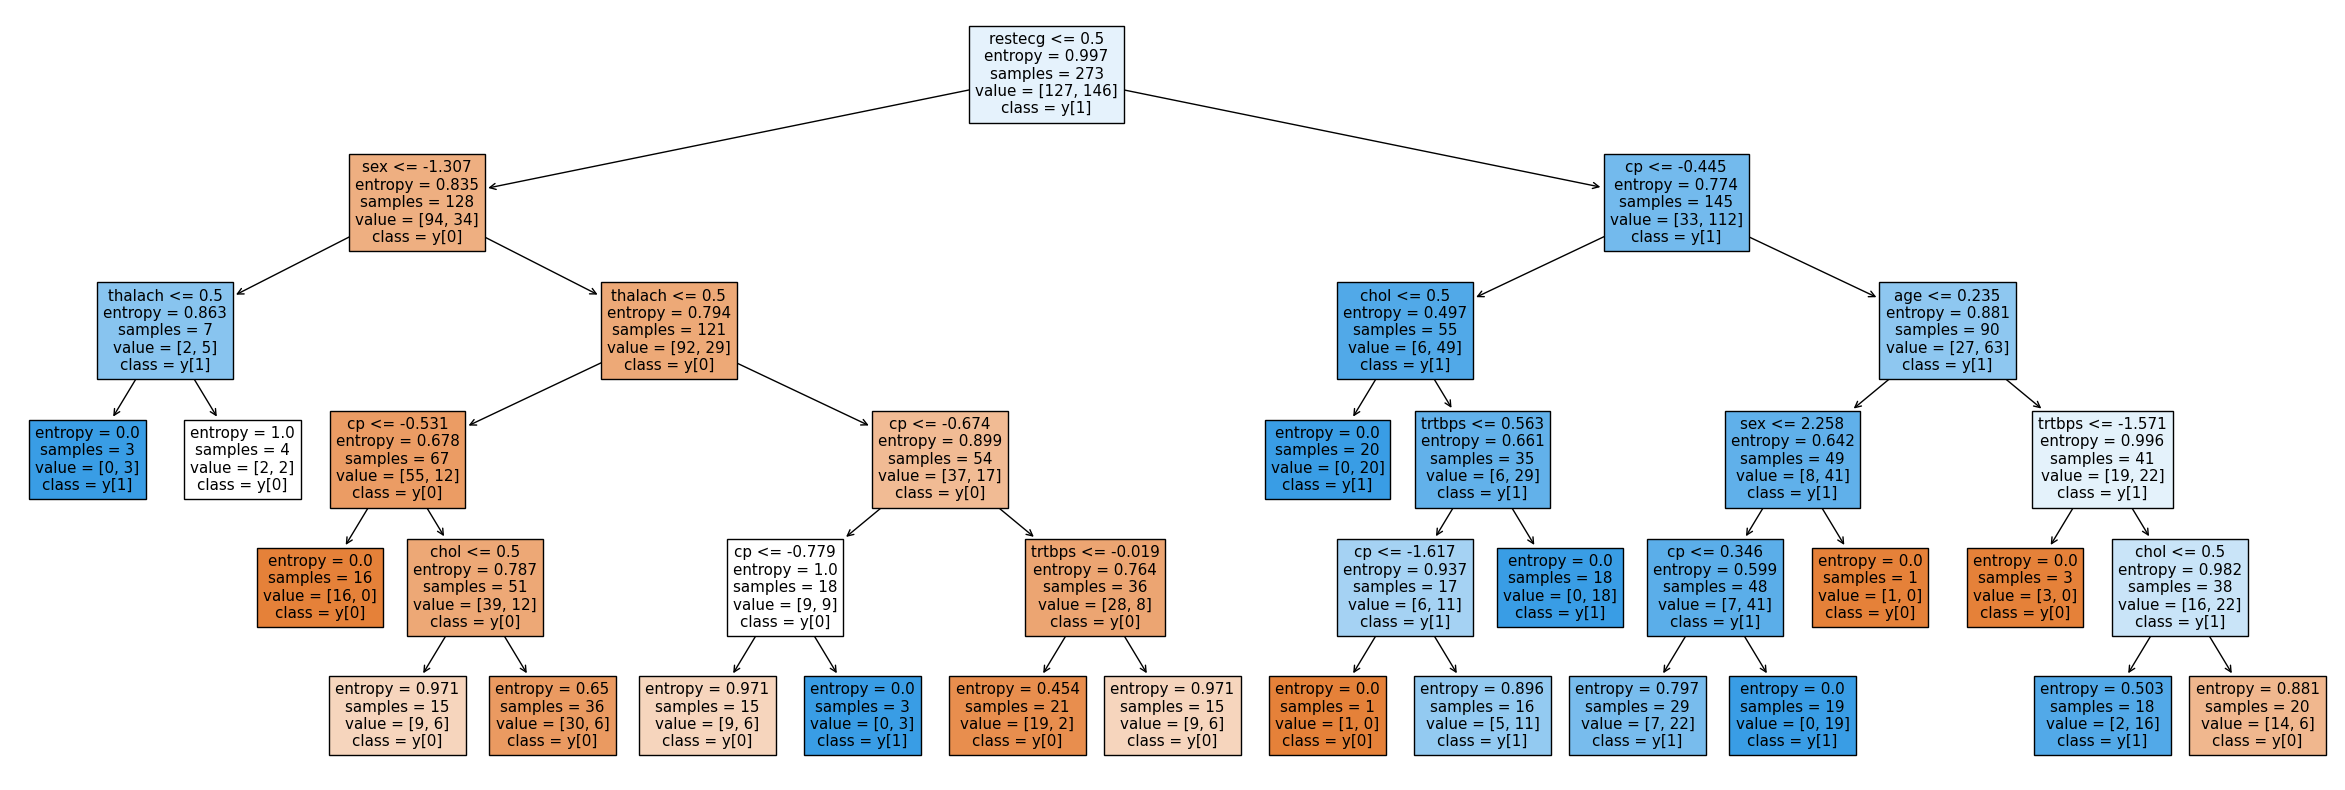

In [210]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# Plotting the decision tree
plt.figure(figsize=(30,10))
plot_tree(best_model3, filled=True, feature_names=feature_names, class_names=True)
plt.show()

*    The root node splits on the variable 'restecg' for chest pain, with values less than or equal to 0.5 sent to the 'sex' node, and values greater going to the 'cp' node. There are 273 samples at this root node, with 127 samples belonging to one class, and 146 samples belonging to the dominant class, y[1]. The gini impurity of 0.997 is extremely high and indicates evenly distributed classes. The subsequent splits should reduce the range of entropy.
*    The final leaf nodes indicate the classification that was made by the decision tree based on the features, along with the number of samples, and the value of each class. Some final leaf nodes ended with the lowest entropy value of 0.00, and these were completely pure nodes, as they had samples that only belonged to one class. The next lowest entropy value was 0.454, and this leaf had 21 samples, and followed the path of restecg <= sex <= thalach <= cp <= trtbps. The final leaf node with the most samples had an entropy value of 0.65, and contained 36 samples. This followed the path of restecg <= sex <= thalach <= cp <= chol.
*    The dataset was small, and the depth of the decision tree was deep enough to possibly introduce some overfitting, even with the tuned hyperparameters.

# **Part Two: Metrics**

Consider the following metrics:

**True Positive Rate** or **Recall** or **Sensitivity** = Of the observations that are truly Class A, how many were predicted to be Class A?

**Precision** or **Positive Predictive Value** = Of all the observations classified as Class A, how many of them were truly from Class A?

**True Negative Rate** or **Specificity** or **Negative Predictive Value** = Of all the observations classified as NOT Class A, how many were truly NOT Class A?

Compute each of these metrics (cross-validated) for your three models (KNN, Logistic Regression, and Decision Tree) in Part One.

In [211]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score, classification_report

In [212]:
# Getting cross-validated predictions on the full model for KNN, Logistic Regression, and Decision Tree
y_pred_knn = cross_val_predict(best_model1, X, y, cv=5)
y_pred_logreg = cross_val_predict(best_model2, X, y, cv=5)
y_pred_dt = cross_val_predict(best_model3, X, y, cv=5)

In [213]:
# KNN CV Metrics
conf_matrix_knn = confusion_matrix(y, y_pred_knn)
tn, fp, fn, tp = conf_matrix_knn.ravel()
recall_knn = recall_score(y, y_pred_knn)
precision_knn = precision_score(y, y_pred_knn)
specificity_knn = tn / (tn + fp)
accuracy_knn = accuracy_score(y, y_pred_knn)
f1_knn = f1_score(y, y_pred_knn)
auc_knn = roc_auc_score(y, y_pred_knn)

# Logistic CV Regression Metrics
conf_matrix_logreg = confusion_matrix(y, y_pred_logreg)
tn, fp, fn, tp = conf_matrix_logreg.ravel()
recall_logreg = recall_score(y, y_pred_logreg)
precision_logreg = precision_score(y, y_pred_logreg)
specificity_logreg = tn / (tn + fp)
accuracy_logreg = accuracy_score(y, y_pred_logreg)
f1_logreg = f1_score(y, y_pred_logreg)
auc_logreg = roc_auc_score(y, y_pred_logreg)

# Decision CV Tree Metrics
conf_matrix_dt = confusion_matrix(y, y_pred_dt)
tn, fp, fn, tp = conf_matrix_dt.ravel()
recall_dt = recall_score(y, y_pred_dt)
precision_dt = precision_score(y, y_pred_dt)
specificity_dt = tn / (tn + fp)
accuracy_dt = accuracy_score(y, y_pred_dt)
f1_dt = f1_score(y, y_pred_dt)
auc_dt = roc_auc_score(y, y_pred_dt)

In [214]:
# Storing the cross-validated full model metrics in a dictionary
metrics_cv = {
    "KNN": {
        "Confusion Matrix": conf_matrix_knn,
        "Recall": recall_knn,
        "Precision": precision_knn,
        "Specificity": specificity_knn,
        "Accuracy": accuracy_knn,
        "F1": f1_knn,
        "AUC": auc_knn},
    "Logistic Regression": {
        "Confusion Matrix": conf_matrix_logreg,
        "Recall": recall_logreg,
        "Precision": precision_logreg,
        "Specificity": specificity_logreg,
        "Accuracy": accuracy_logreg,
        "F1": f1_logreg,
        "AUC": auc_logreg},
    "Decision Tree": {
        "Confusion Matrix": conf_matrix_dt,
        "Recall": recall_dt,
        "Precision": precision_dt,
        "Specificity": specificity_dt,
        "Accuracy": accuracy_dt,
        "F1": f1_dt,
        "AUC": auc_dt}
}

# Iterating over the models
for model_name, model_metrics in metrics_cv.items():
    print(f"{model_name} Metrics:")
    for metric_name, metric_value in model_metrics.items():
        if metric_name == "Confusion Matrix":
            print(f"{metric_name}:\n{metric_value}")
        else:
            print(f"{metric_name}: {metric_value}")
    print()

KNN Metrics:
Confusion Matrix:
[[ 94  33]
 [ 38 108]]
Recall: 0.7397260273972602
Precision: 0.7659574468085106
Specificity: 0.7401574803149606
Accuracy: 0.73992673992674
F1: 0.7526132404181183
AUC: 0.7399417538561104

Logistic Regression Metrics:
Confusion Matrix:
[[ 94  33]
 [ 27 119]]
Recall: 0.815068493150685
Precision: 0.7828947368421053
Specificity: 0.7401574803149606
Accuracy: 0.7802197802197802
F1: 0.7986577181208054
AUC: 0.7776129867328228

Decision Tree Metrics:
Confusion Matrix:
[[ 91  36]
 [ 45 101]]
Recall: 0.6917808219178082
Precision: 0.7372262773722628
Specificity: 0.7165354330708661
Accuracy: 0.7032967032967034
F1: 0.7137809187279152
AUC: 0.7041581274943371



**True Positive Rate** or **Recall** or **Sensitivity** = Of the observations that are truly Class A, how many were predicted to be Class A?

*    For KNN, there were 108 TP and 38 FN observations. This resulted in a **74%** rate of true positive cases that were correctly predicted to be Class A.
*    For Log Regression, there were 119 TP 27 FN observations. This resulted in a **81.5%** of true positive cases that were correctly predicted to be Class A.
*    For Decision Tree, there were 101 TP 45 FN observations. This resulted in a **69.2%** of true positive cases that were correctly predicted to be Class A.

Precision or Positive Predictive Value = Of all the observations classified as Class A, how many of them were truly from Class A?

*    For KNN, there were 108 TP and 33 FP observations. This resulted in a **76.6%** rate of observations that were truly from Class A.
*    For Log Regression, there were 119 TP and 33 FP observations. This resulted in a **78.3%** rate of observations that were truly from Class A.
*    For Decision Tree, there were 101 TP and 36 FP observations. This resulted in a **73.7%** rate of observations that were truly from Class A.

True Negative Rate or Specificity or Negative Predictive Value = Of all the observations classified as NOT Class A, how many were truly NOT Class A?

*    For KNN, there were 94 TN and 33 FP, which resulted in a **74%** rate that were truly not in Class A.
*    For Log Regression, there were 94 TN and 33 FP, which resulted in a **74%** rate that were truly not in Class A.
*    For Decision Tree, there were 91 TN and 36 FP, which resulted in a **71.7%** rate that were truly not in Class A.

# **Part Three: Discussion**

Suppose you have been hired by a hospital to create classification models for heart attack risk.

The following questions give a possible scenario for why the hospital is interested in these models. For each one, discuss:

Which metric(s) you would use for model selection and why.

Which of your final models (Part One Q1-3) you would recommend to the hospital, and why.

What score you should expect for your chosen metric(s) using your chosen model to predict future observations.

In [215]:
# Creating a dataframe for comparing cross-validated full model performance metrics
models = ["KNN", "Logistic Regression", "Decision Tree"]
recalls = [recall_knn, recall_logreg, recall_dt]
precisions = [precision_knn, precision_logreg, precision_dt]
specificities = [specificity_knn, specificity_logreg, specificity_dt]
accuracies = [accuracy_knn, accuracy_logreg, accuracy_dt]
f1_scores = [f1_knn, f1_logreg, f1_dt]
auc_scores = [auc_knn, auc_logreg, auc_dt]

data = {
    "Model": models,
    "Recall": recalls,
    "Precision": precisions,
    "Specificity": specificities,
    "Accuracy": accuracies,
    "F1": f1_scores,
    "AUC": auc_scores
}

pd.DataFrame(data)

,Model,Recall,Precision,Specificity,Accuracy,F1,AUC
0,KNN,0.739726,0.765957,0.740157,0.739927,0.752613,0.739942
1,Logistic Regression,0.815068,0.782895,0.740157,0.780220,0.798658,0.777613
2,Decision Tree,0.691781,0.737226,0.716535,0.703297,0.713781,0.704158


In [216]:
# Logistic Regression Recall score for test set predictions
recall_logreg_test = recall_score(y_test, pred_2)

print("Logistic Regression Test Set Metrics:")
print(f"Recall: [{recall_logreg_test}]")

Logistic Regression Test Set Metrics:
Recall: [0.6216216216216216]


In [217]:
# Logistic Regression Specificity score for test set predictions
conf_matrix_logreg_test = confusion_matrix(y_test, pred_2)
tn, fp, fn, tp = conf_matrix_logreg_test.ravel()
specificity_logreg_test = tn / (tn + fp)

print("Logistic Regression Test Set Metrics:")
print(f"Recall: [{specificity_logreg_test}]")

Logistic Regression Test Set Metrics:
Recall: [0.75]


In [218]:
# Logistic Regression Precision score for test set predictions
precision_logreg_test = precision_score(y_test, pred_2)

print("Logistic Regression Test Set Metrics:")
print(f"Precision: [{precision_logreg_test}]")

Logistic Regression Test Set Metrics:
Precision: [0.7419354838709677]


In [219]:
# Logistic Regression Accuracy score for test set predictions
accuracy_logreg_test = accuracy_score(y_test, pred_2)

print("Logistic Regression Test Set Metrics:")
print(f"Accuracy: [{accuracy_logreg_test}]")

Logistic Regression Test Set Metrics:
Accuracy: [0.6811594202898551]


In [220]:
# Logistic Regression Accuracy score for test set predictions
f1_logreg_test = f1_score(y_test, pred_2)

print("Logistic Regression Test Set Metrics:")
print(f"F1: [{f1_logreg_test}]")

Logistic Regression Test Set Metrics:
F1: [0.676470588235294]


# Q1
The hospital faces severe lawsuits if they deem a patient to be low risk, and that patient later experiences a heart attack.

*    Recall should be chosen as the metric to decide the model selection because it prioritizes minimizing false negatives, which in this case are patients predicted as low risk but are actually high risk.
*    The logistic regression model had the highest recall percentage of **81.5%**. When comparing the precision metric, the log regression model was also higher than the other two models. So, in that aspect, it also does the best in minimizing false positives. The specificity rate is also tied with KNN at **74%** and better than the decision tree model, which means it is also the best in correctly identifying patients who are at low risk of heart attack.
*    The test set predictions had a recall of **62.2%**. A recall score between the range of **62.2%** and **81.5%** should be expected to predict future observations.

# Q2
The hospital is overfull, and wants to only use bed space for patients most in need of monitoring due to heart attack risk.

*    Specificity can be used to identify patients who are at actually at low risk among all negative cases. A high specificity will make sure low-risk patients are correctly identified, as the hospital has a limited number of beds to use for patients who are most in need of monitoring due to heart attack risk. Recall should also be considered in order to identify high-risk patients, ensuring that the chance of incorrectly identifying these patients is minimized.
*    Both the KNN and Logistic Regression models have the highest specificity, at **74.0%**, so the recall score should be considered. Logistic regression again is the better model, as it has a higher recall score of **81.5%**, as compared to the KNN recall score of **74%**.
*    The test set predictions had a specificity score of **75%**, so a range of **74%** to **75%** should be expected to predict future observations.

# Q3
The hospital is studying root causes of heart attacks, and would like to understand which biological measures are associated with heart attack risk.

*    Analyzing the precision score can aid in identifying the biological measures that show a strong association with heart attacks. This score indicates that when the model makes a prediction, it is more likely to be accurate, helping to determine the features most relevant to the prediction of heart attacks. However, precision along with other metrics such as recall, and specificity should all be considered when choosing a model.
*    The precision score for Logistic Regression, **78.3%** is also higher than the other two models, while also having the highest recall, **81.5%**, and tied for the highest specificity, **74%**. The Logistic Regression model should be chosen.
*    The test set predictions had a precision score of **74.2%**, so a range of **74.2%** to **78.3%** should be expected to predict future observations.

# Q4
The hospital is training a new batch of doctors, and they would like to compare the diagnoses of these doctors to the predictions given by the algorithm to measure the ability of new doctors to diagnose patients.

*    Accuracy should be used to make a general assessment of the models as its score will determine how often the new batch of doctors and the algorithm are correct in their diagnoses. Accuracy considers true positives and true negatives and focuses on the correct predictions made by the models. However, accuracy can be misleading if there is an unbalanced ratio of patients who are at risk and those who are not. After accuracy is considered, F1 score should be considered because it balances recall and precision and is important when diagnosing those who are actually at risk and identifying if these diagnoses are accurate. For the new batch of doctors, a high recall score will indicate if they are effectively diagnosing the patients who are actually at risk and a high F1 score will assess whether or not the new doctors’ diagnoses are accurate.
*    The accuracy score for the Logistic Regression model was **78%**, and this was higher than the other two models. It also had the highest F1 score, **80%**. The Logistic Regression model should be chosen again.
*    The test set predictions had a accuracy score of **68.1%**, so a range of **68.1%** to **78%** should be considered. For F1, the test set reported a score of **67.6%**, so a range of **67.6%** to **80%** should be expected.

# **Part Four: Validation**

Before sharing the dataset with you, I set aside a random 10% of the observations to serve as a final validation set.

ha_validation <- pd.read_csv("https://www.dropbox.com/s/jkwqdiyx6o6oad0/heart_attack_validation.csv?dl=1")

Use each of your final models in Part One Q1-3, predict the target variable in the validation dataset.

For each, output a confusion matrix, and report the ROC AUC, the precision, and the recall.

Compare these values to the cross-validated estimates you reported in Part One and Part Two. Did our measure of model success turn out to be approximately correct for the validation data?

In [221]:
# Importing the validation set
ha_validation = pd.read_csv("https://www.dropbox.com/s/jkwqdiyx6o6oad0/heart_attack_validation.csv?dl=1")

In [222]:
# Checking for counts of rows and columns
ha_validation.shape

(30, 8)

*There are only 30 observations in the validation set, which might result in some fluctuations in metric performances.*

In [223]:
# Checking the value counts of the 'output' variable
ha_validation['output'].value_counts()

1    19
0    11
Name: output, dtype: int64

*The ratio of 1 to 0 is almost 2:1, which is unbalanced when compared to what the best model was trained on.*

In [224]:
# Defining the validation response and predictor variables
X1 = ha_validation.drop('output', axis=1)
y1 = ha_validation['output']

# Preprocessing the validation data
X1 = ct.transform(X1)

In [225]:
# Predicting with the best KNN model
pred_v1 = best_model1.predict(X1)

# Predicting with the best Logistic Regression model
pred_v2 = best_model2.predict(X1)

# Predicting with the best Decision Tree model
pred_v3 = best_model3.predict(X1)

In [226]:
# KNN Validation Metrics
val_conf_matrix_knn = confusion_matrix(y1, pred_v1)
tn, fp, fn, tp = val_conf_matrix_knn.ravel()
val_recall_knn = recall_score(y1, pred_v1)
val_precision_knn = precision_score(y1, pred_v1)
val_auc_knn = roc_auc_score(y1, pred_v1)

# Logistic Regression Validation Metrics
val_conf_matrix_logreg = confusion_matrix(y1, pred_v2)
tn, fp, fn, tp = val_conf_matrix_logreg.ravel()
val_recall_logreg = recall_score(y1, pred_v2)
val_precision_logreg = precision_score(y1, pred_v2)
val_auc_logreg = roc_auc_score(y1, pred_v2)

# Decision Tree Validation Metrics
val_conf_matrix_dt = confusion_matrix(y1, pred_v3)
tn, fp, fn, tp = val_conf_matrix_dt.ravel()
val_recall_dt = recall_score(y1, pred_v3)
val_precision_dt = precision_score(y1, pred_v3)
val_auc_dt = roc_auc_score(y1, pred_v3)

In [227]:
# Storing the validation metrics in a dictionary
metrics_val = {
    "KNN": {
        "Confusion Matrix": val_conf_matrix_knn,
        "Recall": val_recall_knn,
        "Precision": val_precision_knn,
        "AUC": val_auc_knn},
    "Logistic Regression": {
        "Confusion Matrix": val_conf_matrix_logreg,
        "Recall": val_recall_logreg,
        "Precision": val_precision_logreg,
        "AUC": val_auc_logreg},
    "Decision Tree": {
        "Confusion Matrix": val_conf_matrix_dt,
        "Recall": val_recall_dt,
        "Precision": val_precision_dt,
        "AUC": val_auc_dt}
}

# Iterating over the models
for model_name, model_metrics in metrics_val.items():
    print(f"{model_name} Metrics:")
    for metric_name, metric_value in model_metrics.items():
        if metric_name == "Confusion Matrix":
            print(f"{metric_name}:\n{metric_value}")
        else:
            print(f"{metric_name}: {metric_value}")
    print()

KNN Metrics:
Confusion Matrix:
[[ 9  2]
 [ 6 13]]
Recall: 0.6842105263157895
Precision: 0.8666666666666667
AUC: 0.7511961722488038

Logistic Regression Metrics:
Confusion Matrix:
[[ 9  2]
 [ 4 15]]
Recall: 0.7894736842105263
Precision: 0.8823529411764706
AUC: 0.8038277511961722

Decision Tree Metrics:
Confusion Matrix:
[[10  1]
 [ 8 11]]
Recall: 0.5789473684210527
Precision: 0.9166666666666666
AUC: 0.7440191387559808



In [228]:
# Comparing the CV full model metrics to the validation set metrics
# Metrics from cross-validation
metrics_cv = {
    "KNN": {"Recall": 0.7397, "Precision": 0.7660, "AUC": 0.7399},
    "Logistic Regression": {"Recall": 0.8151, "Precision": 0.7829, "AUC": 0.7776},
    "Decision Tree": {"Recall": 0.6918, "Precision": 0.7372, "AUC": 0.7042}
}

# Metrics from validation
metrics_val = {
    "KNN": {"Recall": 0.6842, "Precision": 0.8667, "AUC": 0.7512},
    "Logistic Regression": {"Recall": 0.7895, "Precision": 0.8824, "AUC": 0.8038},
    "Decision Tree": {"Recall": 0.5789, "Precision": 0.9167, "AUC": 0.7440}
}

# Creating a dataframe for comparison
comparison_data = []
for model in metrics_cv.keys():
    for metric in metrics_cv[model].keys():
        row = {
            "Model": model,
            "Metric": metric,
            "CV Value": metrics_cv[model][metric],
            "Validation Value": metrics_val[model][metric]
        }
        comparison_data.append(row)

pd.DataFrame(comparison_data)

,Model,Metric,CV Value,Validation Value
0,KNN,Recall,0.7397,0.6842
1,KNN,Precision,0.7660,0.8667
2,KNN,AUC,0.7399,0.7512
3,Logistic Regression,Recall,0.8151,0.7895
4,Logistic Regression,Precision,0.7829,0.8824
5,Logistic Regression,AUC,0.7776,0.8038
6,Decision Tree,Recall,0.6918,0.5789
7,Decision Tree,Precision,0.7372,0.9167
8,Decision Tree,AUC,0.7042,0.7440


*    When comparing recall, logistic regression had the highest score on the validation set (**79.0%**). The decision tree had the lowest recall (**57.9%**). When prioritizing identifying missing true positives, logistic regression is the best model based on the results.
*    When comparing precision, decision tree had the highest validation score (**91.7%**), which indicates it is the best model in terms of minimizing false positives. Logistic regression (**88.2%**) also performs well regarding precision, while KNN had the lowest score (**86.7%**).
*    When comparing AUC, logistic regression had the highest validation score (**80.4%**) which indicates the best overall performance when comparing the different classes.
*    Logistic regression is the best model, with the highest scores in recall and AUC, and the second highest score in precision. It is the most effective in identifying true positives while also maintaining a low rate of false positives.
*    Decision tree had the highest precision but is behind the logistic regression in terms recall and AUC, which might indicate it is too conservative when predicting positive cases.
*    KNN did not perform particularly well when compared to the other two models.
*    The validation set was only thirty observations, with some unbalances in the response variable, when compared to the dataset the best models were trained on. This could be the cause of some unexpected behavior in the validation metrics. Overall, the logistic regression model showed the least amount of variation between the cross-validated and validation metrics.

# **Part Five: Cohen’s Kappa**

Another common metric used in classification is Cohen’s Kappa.

Use online resources to research this measurement. Calculate it for the models from Part One, Q1-3, and discuss reasons or scenarios that would make us prefer to use this metric as our measure of model success. Do your conclusions from above change if you judge your models using Cohen’s Kappa instead? Does this make sense?

In [229]:
from sklearn.metrics import cohen_kappa_score

In [230]:
# Getting cross-validated predictions on the full model for KNN, Logistic Regression, and Decision Tree
y_pred_knn = cross_val_predict(best_model1, X, y, cv=5)
y_pred_logreg = cross_val_predict(best_model2, X, y, cv=5)
y_pred_dt = cross_val_predict(best_model3, X, y, cv=5)

In [231]:
kappa1 = cohen_kappa_score(y, y_pred_knn)
kappa2 = cohen_kappa_score(y, y_pred_logreg)
kappa3 = cohen_kappa_score(y, y_pred_dt)

In [232]:
print(f"Cohen's Kappa Full Model Metrics:\n")
print(f"Kappa Value KNN: [{kappa1:.4f}]")
print(f"Kappa Coefficient of Determination KNN: [{np.sqrt(kappa1):.2f}]\n")
print(f"Kappa Logistic Regression: [{kappa2:.4f}]")
print(f"Kappa Coefficient of Determination Logistic Regression: [{np.sqrt(kappa2):.2f}]\n")
print(f"Kappa Decision Tree: [{kappa3:.4f}]")
print(f"Kappa Coefficient of Determination Decision Tree: [{np.sqrt(kappa3):.2f}]")

Cohen's Kappa Full Model Metrics:

Kappa Value KNN: [0.4787]
Kappa Coefficient of Determination KNN: [0.69]

Kappa Logistic Regression: [0.5569]
Kappa Coefficient of Determination Logistic Regression: [0.75]

Kappa Decision Tree: [0.4064]
Kappa Coefficient of Determination Decision Tree: [0.64]


*    The highest Cohen's Kappa value was from the logistic regression model (0.5569), and this represented a moderate agreement between the model's predictions and its actual values. The lowest value was the decision tree model (0.4064), and this represented a fair agreement between the predictions and actual values.
*    The logistic regression model is still the best model based on the Kappa scores. This makes sense as it is consistent with the other metrics reported and aligns with the conclusions drawn from them.
*    Even the highest Kappa COD score of **75%** from the logistic regression model can be seen as problematic, especially in a healthcare setting. **25%** of the data in the full model represent faulty data and this would be unacceptable in terms of diagnosing what patients are at risk of heart attack.
*    When kappa values are below 0.60, which represents moderate agreement, the confidence intervals about the kappa are wide enough that to state that almost **50%** of the data may be faulty. Statistical significance has no bearing when almost half of the data may be incorrect.
*    In a healthcare setting, Cohen's Kappa would be the preferred classification model because it adjusts for any imbalances in the dataset as well as providing a more realistic analysis of the model's performance. The cost of incorrectly predicting a heart attack (false negative) is too great to accept moderate or adequate agreement between the predictions and actual values.